# Parameter Estimation for Reverse Osmosis Systems

**WaterTAP Academy Tutorial**

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. Understand what parameter estimation is and why it matters for water treatment modeling
2. Prepare experimental data for use with Pyomo's `parmest` tool
3. Define a model function that connects the RO model to data
4. Solve parameter estimation problems to fit membrane transport parameters (A and B coefficients)
5. Visualize and validate your results against experimental data

---

## Background

### Why Parameter Estimation?

Reverse osmosis membrane models rely on transport parameters that characterize how water and solutes move through the membrane:

- **A coefficient (water permeability)**: How easily water passes through the membrane (m/Pa/s)
- **B coefficient (salt permeability)**: How easily dissolved solids pass through (m/s)

**Parameter estimation** allows us to calibrate the transport parameters of our models based on the data, making our simulations more accurate and useful for design and optimization.

### Data Source

This tutorial uses data from the pilot pant of **Orange County Water District (OCWD)** —a water treatment plant in California that has RO facilities.

---

## Part 1: Setting Up Parameter Estimation

### Step 1.1: Import Required Modules

Import modules from:
- **Pyomo**: Core optimization and parameter estimation (`parmest`)
- **IDAES**: Flowsheet infrastructure and utilities
- **WaterTAP**: RO unit models and property packages
- **Other packages**: pandas, numpy, matplotlib

In [1]:
# === Pyomo Imports ===
from pyomo.environ import (
    ConcreteModel,
    value,
    TransformationFactory,
    assert_optimal_termination,
)
from pyomo.network import Arc
import pyomo.contrib.parmest.parmest as parmest

# === IDAES Imports ===
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Separator
from idaes.core.util.initialization import propagate_state
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.core.util.scaling as iscale
import idaes.logger as idaeslog

# === WaterTAP Imports ===
from watertap.unit_models.reverse_osmosis_0D import (
    ReverseOsmosis0D as RO,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
)
from watertap.property_models import seawater_prop_pack as props
from watertap.core.solvers import get_solver

# === Data & Visualization ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utility_functions import load_data

# === Suppress verbose logging ===
import logging
import warnings
logging.getLogger("pyomo").setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

print("✓ All modules imported successfully!")

✓ All modules imported successfully!


### Step 1.2: Load and Prepare Data

**Key Concept**: `parmest` requires data in the following formats:
1. **Pandas DataFrame** (we'll use this) — each row is one experimental scenario
2. List of dictionaries
3. List of JSON file names (for large parallel computing jobs)

Our data includes:
- **Inputs**: Feed flow rate, TDS concentration, inlet pressure, pressure drop
- **Outputs** (what we're fitting to): Permeate flow rate and TDS concentration

In [2]:
# Load raw data from CSV
raw_data = pd.read_csv("Plant_data.csv")

# Process data (load_data handles rename, filtering, and other pretreatment)
data, full_data = load_data(raw_data)

print("\n--- Data Preview ---")
display(data)


--- Data Preview ---


,flow_vol_in,mass_frac_TDS_in,pressure_in,deltaP,flow_vol_permeate,mass_frac_TDS_permeate
31,6.011,0.001276,179.121,11.701,4.687,0.000024
32,6.035,0.001275,179.166,11.611,4.716,0.000025
33,6.049,0.001275,179.030,11.565,4.732,0.000025
34,6.037,0.001276,178.895,11.656,4.718,0.000024
35,6.024,0.001271,178.804,11.655,4.710,0.000025
36,6.050,0.001275,178.985,11.565,4.724,0.000025
37,6.060,0.001272,178.985,11.656,4.740,0.000025
38,6.034,0.001276,179.121,11.746,4.708,0.000024
39,6.035,0.001278,179.075,11.565,4.704,0.000025
40,6.026,0.001280,179.211,11.610,4.712,0.000025


#### 💡 Understanding the Data Columns

| Column | Description | Units |
|--------|-------------|-------|
| `flow_vol_in` | Feed volumetric flow rate | GPM |
| `mass_frac_TDS_in` | Feed TDS mass fraction | - |
| `pressure_in` | Feed pressure | psi |
| `deltaP` | Pressure drop across membrane | psi |
| `flow_vol_permeate` | Permeate flow rate | GPM |
| `mass_frac_TDS_permeate` | Permeate TDS | - |

### Step 1.3: Define the Model Function

The pilot plant data uses imperial units, but WaterTAP models use SI units internally.

In [3]:
# Initialize solver
solver = get_solver()

# Unit conversion factors
PSI_TO_PA = 6894.75        # psi → Pascal
GPM_TO_M3PS = 6.309e-5     # GPM → m³/s


**Critical**: `parmest` requires a "model function" to be defined that takes in the data and returns a Pyomo model.

For this example, the RO model we are proposing is defined as `ro_parmest` function, the parameters we want to estimate (`A_comp` and `B_comp`) should be initialized during model building—`parmest` will unfix and optimize them.


In [4]:
def ro_parmest(data):
    """
    Build an RO model configured for parameter estimation.
    
    Args:
        data: DataFrame with a single row of operating conditions
        
    Returns:
        Pyomo ConcreteModel with 0 degrees of freedom
    """
    # ===== BUILD FLOWSHEET =====
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = props.SeawaterParameterBlock()
    
    # Add units
    m.fs.feed = Feed(property_package=m.fs.properties)
    m.fs.RO = RO(
        property_package=m.fs.properties,
        has_pressure_change=True,
        concentration_polarization_type=ConcentrationPolarizationType.none,
        mass_transfer_coefficient=MassTransferCoefficient.none,
    )
    
    # Connect units
    m.fs.s00 = Arc(source=m.fs.feed.outlet, destination=m.fs.RO.inlet)
    TransformationFactory("network.expand_arcs").apply_to(m)
    
    # ===== INITIAL CONDITIONS (for initialization) =====
    m.fs.feed.properties[0].flow_vol_phase.fix(GPM_TO_M3PS * 8)
    m.fs.feed.properties[0].temperature.fix(273.15 + 25)  # 25°C
    m.fs.feed.properties[0].pressure.fix(PSI_TO_PA * 188)
    m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(0.001)
    
    # Membrane configuration
    m.fs.RO.area.fix(28.8)
    m.fs.RO.permeate.pressure[0].fix(101325)  # Atmospheric
    m.fs.RO.deltaP.fix(-PSI_TO_PA * 24.6)
    
    # ===== PARAMETERS TO ESTIMATE =====
    # Initial guesses for A and B coefficients
    m.fs.RO.A_comp[0, "H2O"].fix(5e-12)  # Water permeability
    m.fs.RO.B_comp[0, "TDS"].fix(4e-8)   # Salt permeability
    
    # ===== SCALING =====
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e1, index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e6, index=("Liq", "TDS")
    )
    iscale.set_scaling_factor(m.fs.RO.area, 1e-1)
    iscale.calculate_scaling_factors(m)
    
    # ===== INITIALIZE =====
    solver.solve(m.fs.feed)
    propagate_state(m.fs.s00)
    m.fs.RO.initialize(outlvl=idaeslog.ERROR)
    
    # ===== SET ACTUAL OPERATING CONDITIONS FROM DATA =====
    m.fs.feed.properties[0].flow_vol_phase.fix(
        GPM_TO_M3PS * float(data.iloc[0]["flow_vol_in"])
    )
    m.fs.feed.properties[0].pressure.fix(
        PSI_TO_PA * float(data.iloc[0]["pressure_in"])
    )
    m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(
        float(data.iloc[0]["mass_frac_TDS_in"])
    )
    m.fs.RO.deltaP.fix(-PSI_TO_PA * float(data.iloc[0]["deltaP"]))
    
    # Verify DOF = 0
    assert degrees_of_freedom(m) == 0, f"DOF = {degrees_of_freedom(m)}, expected 0"
    
    return m

print("✓ Model function defined")

✓ Model function defined


### Step 1.4: Specify Parameters to Estimate

The variables to be estimated by parmest must be given as a list of strings of the variable names as they are defined in the `ro_parmest`. 

In [5]:
# Parameter names (must match exactly how they appear in the model)
theta_names = [
    "fs.RO.A_comp[0, 'H2O']",  # Water permeability coefficient
    "fs.RO.B_comp[0, 'TDS']"   # Salt permeability coefficient
]

print("Parameters to estimate:")
for name in theta_names:
    print(f"  • {name}")

Parameters to estimate:
  • fs.RO.A_comp[0, 'H2O']
  • fs.RO.B_comp[0, 'TDS']


### Step 1.5: Define the Objective Function

We minimize the **sum of squared errors (SSE)** between model predictions and measurements.

**Important**: We normalize by the standard deviation of each output to ensure both output variables to be the same scale.

$$\text{SSE} = \left(\frac{Q_{perm}^{data} - Q_{perm}^{model}}{\sigma_Q}\right)^2 + \left(\frac{x_{TDS}^{data} - x_{TDS}^{model}}{\sigma_x}\right)^2$$

In [6]:
def SSE(m, data):
    
    # Normalization factors
    flow_std = np.std(GPM_TO_M3PS * full_data["flow_vol_permeate"])
    tds_std = np.std(full_data["mass_frac_TDS_permeate"])
    
    # Data values
    flow_measured = GPM_TO_M3PS * float(data.iloc[0]["flow_vol_permeate"])
    tds_measured = float(data.iloc[0]["mass_frac_TDS_permeate"])
    
    # Model predictions
    flow_model = m.fs.RO.mixed_permeate[0.0].flow_vol_phase["Liq"]
    tds_model = m.fs.RO.mixed_permeate[0.0].mass_frac_phase_comp["Liq", "TDS"]
    
    # Normalized SSE
    expr = ((flow_measured - flow_model) / flow_std)**2 + \
           ((tds_measured - tds_model) / tds_std)**2
    
    return expr

print("✓ Objective function defined")

✓ Objective function defined


---

## Part 2: Solve the Parameter Estimation Problem

### Step 2.1: Create the Estimator

Now, we have everything we need for ``parmest`` to solve the parameter estimation problem: 

    - ro_parmest
    - data
    - theta_names
    - objective_function
    
Then, we can set up the parameter estimation problem by creating an instance of the parmest 'Estimator' object and feed it the required inputs:

In [7]:
# Create parmest Estimator object
pest = parmest.Estimator(
    ro_parmest,    # Model function
    data,          # Training data
    theta_names,   # Parameters to estimate
    SSE,           # Objective function
    tee=False      # Suppress solver output
)

print("✓ Estimator created")
print(f"  Training scenarios: {len(data)}")
print(f"  Parameters: {len(theta_names)}")

✓ Estimator created
  Training scenarios: 10
  Parameters: 2


### Step 2.2: Solve and Display Results

Solve the parameter estimation problem by calling ``theta_est``. This will use the entire data set to perform the parameter estimation. 

There are additional options for solving and testing. Further details can be found in the [parmest documentation](https://pyomo.readthedocs.io/en/6.7.0/contributed_packages/parmest/index.html).

In [8]:
# Solve the parameter estimation problem
print("Solving parameter estimation...")
obj, theta = pest.theta_est()

print("\n" + "="*50)
print("PARAMETER ESTIMATION RESULTS")
print("="*50)
print(f"\nOptimal objective value: {obj:.6f}")
print("\nEstimated parameters:")
print(f"  A (water permeability): {theta.iloc[0]:.6e} m/Pa/s")
print(f"  B (salt permeability):  {theta.iloc[1]:.6e} m/s")

Solving parameter estimation...

PARAMETER ESTIMATION RESULTS

Optimal objective value: 0.005146

Estimated parameters:
  A (water permeability): 1.217544e-11 m/Pa/s
  B (salt permeability):  7.283319e-08 m/s


---

## Part 3: Validate and Visualize Results

Finally, we can visualize the results using ***matplotlib*** to create a plot of the data and the parameter estimatation fit. 

### Step 3.1: Create Prediction Function with Optimal Parameters

In [9]:
def ro_opt(theta):
    """
    Build an RO model with the optimal estimated parameters.
    
    Args:
        theta: Series containing optimal A and B values
        
    Returns:
        Initialized Pyomo model ready for simulation
    """
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = props.SeawaterParameterBlock()
    m.fs.feed = Feed(property_package=m.fs.properties)
    m.fs.RO = RO(
        property_package=m.fs.properties,
        has_pressure_change=True,
        concentration_polarization_type=ConcentrationPolarizationType.none,
        mass_transfer_coefficient=MassTransferCoefficient.none,
    )

    m.fs.s00 = Arc(source=m.fs.feed.outlet, destination=m.fs.RO.inlet)
    TransformationFactory("network.expand_arcs").apply_to(m)

    # Initial conditions
    m.fs.feed.properties[0].flow_vol_phase.fix(GPM_TO_M3PS * 8)
    m.fs.feed.properties[0].temperature.fix(273.15 + 25)
    m.fs.feed.properties[0].pressure.fix(PSI_TO_PA * 188)
    m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(0.001)

    m.fs.RO.area.fix(28.8)
    m.fs.RO.permeate.pressure[0].fix(101325)
    m.fs.RO.deltaP.fix(-PSI_TO_PA * 24.6)

    # SET OPTIMAL PARAMETERS
    m.fs.RO.A_comp[0, "H2O"].fix(theta.iloc[0])
    m.fs.RO.B_comp[0, "TDS"].fix(theta.iloc[1])

    # Scaling
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e1, index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e6, index=("Liq", "TDS")
    )
    iscale.set_scaling_factor(m.fs.RO.area, 1e-1)
    iscale.calculate_scaling_factors(m)

    # Initialize
    solver.solve(m.fs.feed)
    propagate_state(m.fs.s00)
    m.fs.RO.initialize(outlvl=idaeslog.ERROR)

    assert degrees_of_freedom(m) == 0
    return m

print("✓ Optimal model function defined")

✓ Optimal model function defined


### Step 3.2: Generate Model Predictions and Save Results
Define ``save_model_results`` function to run model for each data point and save predictions

In [10]:
def save_model_results(model_results, m):
    """
    Run model for each data point and save predictions.
    """
    for i in range(model_results.shape[0]):
        # Update operating conditions
        m.fs.feed.properties[0].flow_vol_phase.fix(
            GPM_TO_M3PS * float(model_results.iloc[i]["flow_vol_in"])
        )
        m.fs.feed.properties[0].pressure.fix(
            PSI_TO_PA * float(model_results.iloc[i]["pressure_in"])
        )
        m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(
            float(model_results.iloc[i]["mass_frac_TDS_in"])
        )
        m.fs.RO.deltaP.fix(-PSI_TO_PA * float(model_results.iloc[i]["deltaP"]))

        # Solve
        results = solver.solve(m, tee=False)
        assert_optimal_termination(results)

        # Save predictions
        model_results.iloc[i, model_results.columns.get_loc("flow_vol_permeate")] = (
            value(m.fs.RO.mixed_permeate[0.0].flow_vol_phase["Liq"]) / GPM_TO_M3PS
        )
        model_results.iloc[i, model_results.columns.get_loc("mass_frac_TDS_permeate")] = value(
            m.fs.RO.mixed_permeate[0.0].mass_frac_phase_comp["Liq", "TDS"]
        )
    
    return model_results

Initialize the model with the optimal parameters, create a table named ``model_results`` and save the output predictions in the new table.

In [11]:
# Initialize model with optimal parameters and generate predictions
m = ro_opt(theta)
model_results = full_data.copy()
model_results = save_model_results(model_results, m)

print("✓ Model predictions saved for all data points")

✓ Model predictions saved for all data points


### Step 3.3: Visualize Results

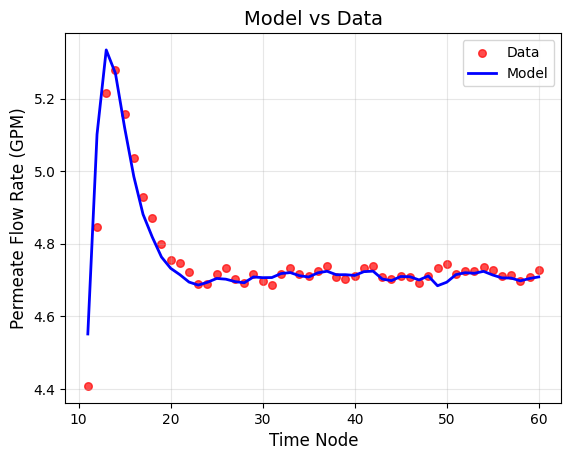

In [12]:
fig, ax = plt.subplots()
ax.scatter(
    full_data.index, 
    full_data["flow_vol_permeate"], 
    label="Data", 
    color="red", 
    s=30,
    alpha=0.7
)
ax.plot(
    model_results.index, 
    model_results["flow_vol_permeate"], 
    label="Model",
    color="blue",
    linewidth=2
)
ax.set_xlabel("Time Node", fontsize=12)
ax.set_ylabel("Permeate Flow Rate (GPM)", fontsize=12)
ax.set_title("Model vs Data", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

---

## Part 4: Hands-On Exercise

### 🎯 Your Challenge

Use a **different subset of the data** to estimate parameters and compare results.

The data set is provided as below named as ``data2``

In [13]:
# Here's a different subset of the data
data2 = full_data.iloc[30:40].copy()
print(f"New training data: indices {data2.index[0]} to {data2.index[-1]}")
display(data2)

New training data: indices 41 to 50


,flow_vol_in,mass_frac_TDS_in,pressure_in,deltaP,flow_vol_permeate,mass_frac_TDS_permeate
41,6.054,0.001280,179.256,11.655,4.733,0.000025
42,6.067,0.001279,179.075,11.655,4.740,0.000025
43,6.022,0.001281,178.849,11.655,4.707,0.000025
44,6.011,0.001285,178.940,11.656,4.703,0.000025
45,6.039,0.001285,178.985,11.610,4.710,0.000025
46,6.036,0.001285,178.985,11.565,4.709,0.000025
47,6.006,0.001285,179.121,11.656,4.691,0.000024
48,6.038,0.001285,179.030,11.520,4.711,0.000024
49,6.062,0.001351,179.166,11.520,4.733,0.000025
50,6.071,0.001347,179.392,11.565,4.743,0.000024


### Exercise 4.1: Set Up a New Estimator with ``data2``

In this problem, we use the same model function ``ro_parmest``, parameter names ``theta_names``, and objective function ``SSE``, with a different data set ``data2``. We name the parameter estimation problem as ``pest2``

<details>
<summary>💡 Click the arrow for Solutions</summary>

```python
pest2 = parmest.Estimator(ro_parmest, data2, theta_names, SSE, tee=False)
```
</details>

In [14]:
# YOUR CODE HERE
# pest2 = ...
pest2 = parmest.Estimator(ro_parmest, data2, theta_names, SSE, tee=False)

### Exercise 4.2: Solve Parmeter Estimation and Display Optimal Parameters as ``theta2``

The objective function is saved as ``obj2`` and optimal parameters are saved as ``theta2``.

<details>
<summary>💡 Click the arrow for Solutions</summary>

```python
obj2, theta2 = pest2.theta_est()
print(f"  A (water permeability): {theta2.iloc[0]:.6e} m/Pa/s")
print(f"  B (salt permeability):  {theta2.iloc[1]:.6e} m/s")
```
</details>

In [15]:
# YOUR CODE HERE
# obj2, theta2 = ...


  A (water permeability): 1.223574e-11 m/Pa/s
  B (salt permeability):  7.191021e-08 m/s


### Exercise 4.3: Generate Predictions and Save to a New Table ``model_results2``

 - First, initialize the model with ``theta2`` and return the optimal model ``m2``
 - Then, create a new table named ``model_results2``
 - Finally, save the results in the new table using ``save_model_results`` function

<details>
<summary>💡 Click the arrow for Solutions</summary>

```python
m2 = ro_opt(theta2)
model_results2 = full_data.copy()
model_results2 = save_model_results(model_results2, m2)
```
</details>

In [16]:
# YOUR CODE HERE
# m2 = ...


### Exercise 4.4: Create Comparison Plot with The Model Results Labled as ``Model2``

 - Plot the ``model_results2`` in the same ``ax`` and set the label as ``Model2`` in the same ``ax`` 
 - Update the legend to include the new results by ``ax.legend()``
 - Display the figure by ``display(fig)``

<details>
<summary>💡 Click the arrow for Solutions</summary>

```python
ax.plot(model_results2.index, model_results2["flow_vol_permeate"], label="Model 2", linewidth=2, color="orange", linestyle="--")
ax.legend()
display(fig)
```
</details>

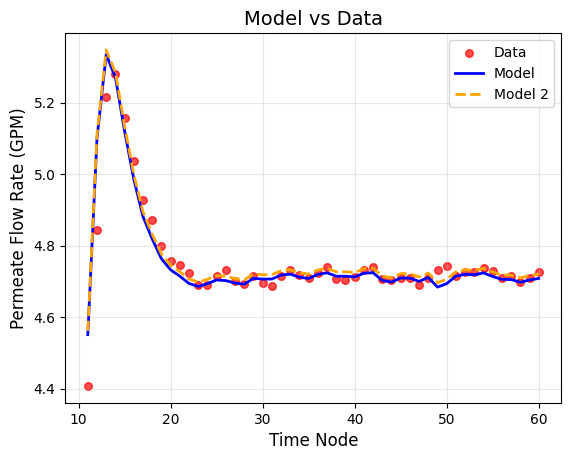

In [17]:
# YOUR CODE HERE
# ax.plot...
